# <font color='red'>**Sequence to sequence implementation**</font>

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

In [ ]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

--2020-12-31 08:10:27--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 172.67.173.198, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7521114 (7.2M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.17M  18.3MB/s    in 0.4s    

2020-12-31 08:10:27 (18.3 MB/s) - ‘ita-eng.zip’ saved [7521114/7521114]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [ ]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2020-12-31 08:10:29--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2020-12-31 08:10:29--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9e7ab3a44f07be5b680cf29999.dl.dropboxusercontent.com/cd/0/inline/BGE0EErqurkdDF8NHJJ_aRbxIVxnR2W4z83STYW2ZixUmwoJnJiFRbH2V6c59WbhLaIBQs_1m2gibUZ-vFN-pa_tlJ5MvoPqytuK-2MxjT7TvP9Lnw4K9j5IyjPJaic71fY/file# [following]
--2020-12-31 08:10:29--  https://uc9e7ab3a44f07be5b680cf29999.dl.dropboxusercontent.com/cd/0/inline/BGE0EErqurkdDF8NHJJ_aRbxIVxnR2W4z83STYW2ZixUmwoJnJiFRbH2V6c59WbhLaIBQs_1m2gibUZ-vFN-pa_tlJ5MvoPq

<font color='blue'>**Load the data**</font>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(343813, 2)


,english,italian
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'

    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,run,corri
2,run,corra
3,run,correte
4,who,chi


In [ ]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(ita_lengths, i))
for i in range(90,101):
    print(i,np.percentile(ita_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_lengths, i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 92.0
99.1 12.0
99.2 12.0
99.3 13.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 20.0
100 92.0


In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(eng_lengths, i))
for i in range(90,101):
    print(i,np.percentile(eng_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

0 1.0
10 4.0
20 4.0
30 5.0
40 5.0
50 6.0
60 6.0
70 7.0
80 7.0
90 8.0
100 101.0
90 8.0
91 9.0
92 9.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 101.0
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 21.18800000002375
100 101.0


In [ ]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,corri,<start> run,run <end>
2,corra,<start> run,run <end>
3,correte,<start> run,run <end>
4,chi,<start> who,who <end>


In [ ]:
data.sample(10)

,italian,english_inp,english_out
124828,tom si vuole trasferire qui,<start> tom wants to move here,tom wants to move here <end>
156154,il papà di tom è molto rigoroso,<start> tom is dad is very strict,tom is dad is very strict <end>
167683,metta più sale nella minestra,<start> put more salt in the soup,put more salt in the soup <end>
41885,siamo partiti assieme,<start> we left together,we left together <end>
323366,tom ha perso il suo lavoro durante lultima rec...,<start> tom lost his job during the last reces...,tom lost his job during the last recession <end>
57112,sono permessi i cani,<start> dogs are permitted,dogs are permitted <end>
287729,non voglio andare a fare jogging con lei,<start> i do not want to go jogging with you,i do not want to go jogging with you <end>
26376,amo insegnare,<start> i love to teach,i love to teach <end>
179667,penso che tu abbia fatto un buon lavoro,<start> i think you did a good job,i think you did a good job <end>
212689,guardi il libro sul banco,<start> look at the book on the desk,look at the book on the desk <end>


<font color='blue'>**Preprocess data**</font>

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [ ]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(274710, 3) (68678, 3)


In [ ]:
train.head()

,italian,english_inp,english_out
63374,ferma il conto alla rovescia,<start> stop the countdown <end>,stop the countdown <end> <end>
266859,dobbiamo uscire da questa tempesta,<start> we have to get out of this storm,we have to get out of this storm <end>
110817,che cosa stai bevendo,<start> what are you drinking,what are you drinking <end>
311876,mary è sia attraente che intelligente,<start> mary is both attractive and intelligent,mary is both attractive and intelligent <end>
311474,io vorrei parlare da solo con tom se posso,<start> i would like to speak to tom alone if ...,i would like to speak to tom alone if i may <end>


In [ ]:
validation.head()

,italian,english_inp,english_out
108634,tom sta leggendo a letto,<start> tom is in bed reading,tom is in bed reading <end>
321527,può fare quel che gli pare con i soldi,<start> he can do whatever he likes with the m...,he can do whatever he likes with the money <end>
317347,cosa potete dirci riguardo a questo dipinto,<start> what can you tell us about this painting,what can you tell us about this painting <end>
121368,lei è in albergo ora,<start> she is at the hotel now,she is at the hotel now <end>
227735,non è il caso in giappone,<start> that is not the case in japan,that is not the case in japan <end>


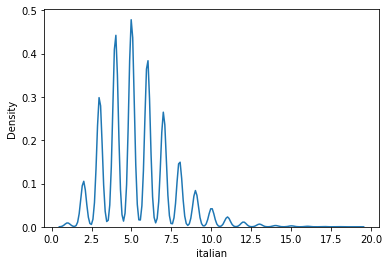

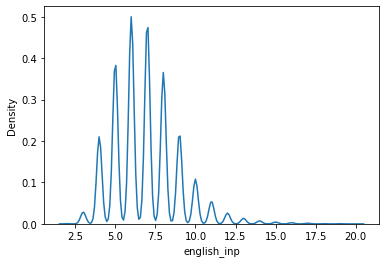

In [ ]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

In [ ]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [ ]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

12798
26094


In [ ]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10087)

In [ ]:
def grader_1(data):
    shape_value = data.shape ==(340044, 3)
    tknizer = Tokenizer(char_level=True)
    tknizer.fit_on_texts(data['italian'].values)
    ita_chars = tknizer.word_index.keys()
    diff_chars_ita = set(ita_chars)-set([' ', 't', 'a', 'o', 'r', 'e', 's', 'i', 'n', 'l', 'c', 'm', 'u', 'd', 'p', 'v', 'h', 'g', 'b', 'f', 'è', 'q', 'z', 'ò', 'à', 'y', 'é', 'ì', 'ù', 'k', 'w', '0', 'j', '1', '3', '2', 'x', '9', '5', '8', '4', '6', '7', 'á', 'ñ', 'ê', 'ü', 'ō', 'î', 'ö', 'ú', 'º'])
    tknizer = Tokenizer(char_level=True)
    tknizer.fit_on_texts(data['english_inp'].values)
    eng_chars = tknizer.word_index.keys()
    diff_chars_eng = set(eng_chars)-set(['<','>',' ', 'e', 'o', 't', 'i', 'a', 'n', 's', 'h', 'r', 'l', 'd', 'm', 'y', 'u', 'w', 'g', 'c', 'p', 'f', 'b', 'k', 'v', 'j', 'x', 'z', 'q', '0', '1', '3', '2', '9', '5', '8', '6', '4', '7'])
    unique_char_value = (len(diff_chars_eng)==0) and (len(diff_chars_ita)==0)
    return unique_char_value and shape_value

grader_1(data)

False

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.layers.Layer):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__()
        self.vocab_size = inp_vocab_size
        self.embedding_dim = embedding_size
        self.input_length = input_length
        self.enc_units= lstm_size
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
        #self.batch_sz = batch_size
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM")



    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embedd                           = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd,initial_state = [states,states])
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c




    def initialize_states(self,batch_size):
      return tf.zeros((batch_size, self.enc_units))

    def get_states(self):
        return self.lstm_state_h,self.lstm_state_c



In [ ]:
class Decoder(tf.keras.layers.Layer):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Decoder LSTM layer
        super().__init__()
        self.vocab_size = out_vocab_size
        self.embedding_dim = embedding_size
        self.dec_units = lstm_size
        self.input_length = input_length
        # we are using embedding_matrix and not training the embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder",trainable=True)
        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Decoder_LSTM")





    def call(self,input_sequence,initial_states,training=True):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm

          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        target_embedd           = self.embedding(input_sequence)
        lstm_output, decoder_final_state_h,decoder_final_state_c       = self.lstm(target_embedd, initial_state=initial_states)
        return lstm_output, decoder_final_state_h,decoder_final_state_c




In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)


class Dataloder(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
train_dataloader[0][1].shape



(1024, 20)

In [ ]:
class Encoder_decoder(tf.keras.Model):

    def __init__(self,embedding_size,units,out_vocab_size,batch_size):

        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.encoder = Encoder(inp_vocab_size=(vocab_size_ita+1), embedding_size=embedding_size, input_length=20, lstm_size=units)
        self.decoder = Decoder(out_vocab_size=(vocab_size_eng+1), embedding_size=embedding_size, input_length=20, lstm_size=units)
        self.dense   =tf.keras.layers.TimeDistributed( Dense(vocab_size_eng+1, activation='softmax'))
        #self.batch_size=batch_size
        self.batch_size=batch_size
        self.initial_state=self.encoder.initialize_states(self.batch_size)
        self.enc_units=units
        self.encoder_output=0
        self.decoder_output=0
        self.encoder_h=0
        self.encoder_c=0



    def call(self,data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer

        Return decoder_outputs
        '''
        inputs,output = data[0], data[1]
        encoder_output, encoder_h, encoder_c = self.encoder(inputs,self.initial_state)


        decoder_output,decoder_hidden,_= self.decoder(output,[encoder_h, encoder_c])

        dense_output = self.dense(decoder_output)
        #print(dense_output.shape)
        return dense_output



In [ ]:
vocab_size_eng

12837

In [ ]:
import datetime
from keras import backend as K
K.clear_session()
import os
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

BATCH_SIZE=1024
model  = Encoder_decoder(units=256,out_vocab_size=vocab_size_eng,embedding_size=100,batch_size=BATCH_SIZE)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//BATCH_SIZE
valid_steps=validation.shape[0]//BATCH_SIZE
history1=model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[tensorboard_callback])
model.summary()

Epoch 1/20
268/268 [==============================] - 133s 478ms/step - loss: 2.1726 - val_loss: 1.6139
Epoch 2/20
268/268 [==============================] - 129s 479ms/step - loss: 1.5571 - val_loss: 1.3576
Epoch 3/20
268/268 [==============================] - 129s 481ms/step - loss: 1.3091 - val_loss: 1.1729
Epoch 4/20
268/268 [==============================] - 129s 481ms/step - loss: 1.1371 - val_loss: 1.0354
Epoch 5/20
268/268 [==============================] - 129s 480ms/step - loss: 1.0007 - val_loss: 0.9197
Epoch 6/20
268/268 [==============================] - 129s 481ms/step - loss: 0.8829 - val_loss: 0.8233
Epoch 7/20
268/268 [==============================] - 129s 480ms/step - loss: 0.7835 - val_loss: 0.7418
Epoch 8/20
268/268 [==============================] - 129s 480ms/step - loss: 0.6969 - val_loss: 0.6731
Epoch 9/20
268/268 [==============================] - 129s 480ms/step - loss: 0.6240 - val_loss: 0.6120
Epoch 10/20
268/268 [==============================] - 129s 480m

In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         pass the predicted_out to the dense layer
         update the states=[state_h,state_c]
         And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
         Update the input_to_decoder with current predictions
  F. Return the predicted sentence
  '''
  sentence = preprocess_ita(input_sentence).strip()
  inputs=tknizer_ita.texts_to_sequences(sentence)

  inputs = [tknizer_ita.word_index[i] for i in sentence.split(' ') if i in tknizer_ita.word_docs ]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                        maxlen=20,
                                                        padding='post')
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  hidden = tf.zeros((1, 256))
  enc_out, enc_hidden,enc_cell_state = model.layers[0](inputs, hidden)
  dec_hidden = [enc_hidden,enc_cell_state]
  dec_input = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)
  for t in range(20):
    predictions, dec_hidden, dec_cell_state = model.layers[1](dec_input,
                                                          dec_hidden)
    dec_hidden=[dec_hidden, dec_cell_state]
    predictions=model.layers[2](predictions)
    predicted_id = tf.argmax(predictions[0][0]).numpy()
    result += tknizer_eng.index_word[predicted_id] + ' '
    if tknizer_eng.index_word[predicted_id] == '<end>':
        return sentence,result
    dec_input = tf.expand_dims([predicted_id], 0)


In [ ]:
predict('tom promise di ritornare prima delle due e mezza')

'tom promised to go back before 230 <end> '

In [ ]:
target=validation['italian'][10000:20000].apply(predict)

In [ ]:
translation=[]
for i,j in target:
  translation.append(j)


In [ ]:
import nltk.translate.bleu_score as bleu
reference = validation['english_out'][10000:20000] # the original
#translation = validation['italian'][10000:20000].apply(predict)[1]
#target=validation['italian'][10000:20000].apply(predict)[1] # trasilated using model
#print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))

In [ ]:
from tqdm import tqdm
score=0
for i,j in tqdm(zip(reference,translation)):
  #print(i,j)
  score+=bleu.sentence_bleu([i.split()], j.split())

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
10000it [00:01, 9921.63it/s]


In [ ]:
print('BLEU score: {}'.format(score/10000))


BLEU score: 0.7292169297599584


## Task -2: Including Attention mechanisum


1. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 **We will create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 We will implemnt "dot" score function
    * In model 2 We will implemnt "general" score function
    * In model 3 We will implemnt "concat" score function.<br>
    


### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.layers.Layer):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__()
        self.vocab_size = inp_vocab_size
        self.embedding_dim = embedding_size
        self.input_length = input_length
        self.enc_units= lstm_size
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
        #self.batch_sz = batch_size
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM")



    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embedd                           = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd,initial_state = [states,states])
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c




    def initialize_states(self,batch_size):
      return tf.zeros((batch_size, self.enc_units))

    def get_states(self):
        return self.lstm_state_h,self.lstm_state_c



<font color='blue'>**Attention**</font>

In [ ]:
from numpy.linalg import multi_dot
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):


    # Please go through the reference notebook and research paper to complete the scoring functions
    super().__init__()

    self.scoring_function=scoring_function.strip()
    self.enc_units=att_units
    self.weig=[]
    self.context_vector=[]


    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
      pass
    if scoring_function == 'general':
      #self.W = self.add_weight('kernal',shape=[self.enc_units,self.enc_units])
      self.W1 = tf.keras.layers.Dense(self.enc_units)
      #self.W2 = tf.keras.layers.Dense(self.enc_units)
      #self.V = tf.keras.layers.Dense(1)
      # Intialize variables needed for General score function here

      pass
    elif scoring_function == 'concat':

      # Intialize variables needed for Concat score function here
      self.W1 = tf.keras.layers.Dense(self.enc_units)
      self.W2 = tf.keras.layers.Dense(self.enc_units)
      self.V = tf.keras.layers.Dense(1)

      pass



  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''

    if self.scoring_function == 'dot':
        # Implement Dot score function here
        decoder_hidden_state = tf.keras.layers.Reshape((self.enc_units, 1))(decoder_hidden_state)



        score = tf.keras.layers.dot([encoder_output,decoder_hidden_state],[2, 1])
        #self.weig=tf.expand_dims(tf.convert_to_tensor(temp_2, dtype=tf.float32),axis=2)
        self.weig = tf.nn.softmax(score, axis=1)
        self.context_vector=self.weig*encoder_output
        self.context_vector = tf.reduce_sum(self.context_vector, axis=1)

    elif self.scoring_function == 'general':
        # Implement General score function here
        decoder_hidden_state = tf.keras.layers.Reshape((self.enc_units, 1))(decoder_hidden_state)
        #score=tf.matmul(decoder_hidden_state,self.W1(encoder_output),transpose_b=True)

        score = tf.keras.layers.dot([self.W1(encoder_output),decoder_hidden_state],[2, 1])
        self.weig = tf.nn.softmax(score, axis=1)
        self.context_vector=self.weig*encoder_output
        self.context_vector = tf.reduce_sum(self.context_vector, axis=1)



    elif self.scoring_function == 'concat':
        # Implement General score function here
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(decoder_hidden_state, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(encoder_output)))

        # attention_weights shape == (batch_size, max_length, 1)
        self.weig = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        self.context_vector = self.weig * encoder_output
        self.context_vector = tf.reduce_sum(self.context_vector, axis=1)

        #return self.context_vector, attention_weights
    return self.context_vector,self.weig




In [ ]:
input_length=10
batch_size=16
att_units=32
scoring_fun='general'
state_h=tf.random.uniform(shape=[batch_size,att_units])
encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
attention=Attention(scoring_fun,att_units)
context_vector,attention_weights=attention(state_h,encoder_output)

<font color='blue'>**OneStepDecoder**</font>

In [ ]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed

      super().__init__()
      self.vocab_size = tar_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.enc_units= dec_units
      self.lstm_output = 0
      self.lstm_state_h=0
      self.lstm_state_c=0
      self.context_vector=0
      self.attention_weights=0
      self.x=0
      self.attention=Attention(score_fun,att_units)
      #context_vector,attention_weights=attention(state_h,encoder_output)
      #self.batch_sz = batch_size
      self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                          mask_zero=True, name="embedding_layer_decoder")
      self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="decoder_LSTM")
      self.dense   =tf.keras.layers.TimeDistributed( Dense(self.vocab_size))



  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B

    '''
    target_embedd           = self.embedding(input_to_decoder)
    self.context_vector,self.attention_weights=self.attention(state_h,encoder_output)
    self.x = tf.concat([tf.expand_dims(self.context_vector, 1), target_embedd], axis=-1)


    #initial_states=[state_h,state_c]
    lstm_output, decoder_final_state_h,decoder_final_state_c  = self.lstm(self.x, initial_state=[state_h,state_c])
    dense_output = self.dense(lstm_output)
    dense_output = tf.reshape(dense_output, (-1, dense_output.shape[2]))
    return dense_output,decoder_final_state_h,decoder_final_state_c, self.attention_weights,self.context_vector



<font color='blue'>**Decoder**</font>

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super().__init__()
      self.vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.enc_units= dec_units
      self.score_fun=score_fun
      self.onestepdecoder=OneStepDecoder(self.vocab_size , self.embedding_dim, self.input_length, self.enc_units ,self.score_fun ,self.enc_units)

    #@tf.function
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook

        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        #print(input_to_decoder.shape,encoder_output.shape)
        all_outputs=tf.TensorArray(tf.float32,size=0,name='output_array',dynamic_size=True)
        #print(self.onestepdecoder)
        i=20
        #all_outputs=[]
        for t in range(20):
          #print(input_to_decoder[:,t:t+1].shape)
          output,state_h,state_c,attention_weights,context_vector=self.onestepdecoder(input_to_decoder[:,t:t+1],encoder_output,decoder_hidden_state,decoder_cell_state)

          decoder_hidden_state=state_h
          decoder_cell_state=state_c
          all_outputs=all_outputs.write(t,output)
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
        return all_outputs









<font color='blue'>**Encoder Decoder model**</font>

In [ ]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,embedding_size,units,score_fun,batch_size):
    #Intialize objects from encoder decoder
    super().__init__() # https://stackoverflow.com/a/27134600/4084039
    self.encoder = Encoder(inp_vocab_size=(vocab_size_ita+1), embedding_size=embedding_size, input_length=20, lstm_size=units)
    self.decoder = Decoder(out_vocab_size=(vocab_size_eng+1), embedding_dim=embedding_size, input_length=20,dec_units=units,score_fun=score_fun,att_units=units)
    self.batch_size=batch_size
    self.initial_state=self.encoder.initialize_states(self.batch_size)
    self.enc_units=units
    self.encoder_output=0
    self.decoder_output=0
    self.encoder_h=0
    self.encoder_c=0


  def call(self,data,training=True):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    inputs,output = data[0], data[1]
    encoder_output, encoder_h, encoder_c = self.encoder(inputs,self.initial_state)


    decoder_output= self.decoder(output,encoder_output,encoder_h, encoder_c)
    #print('first')
    #print(type(decoder_output))

    #dense_output = self.dense(decoder_output)
    return decoder_output




<font color='blue'>**Custom loss function**</font>

In [ ]:
#Reference: https://www.tensorflow.org/tutorials/text/nmt_with_attention
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

<font color='blue'>**Training**</font>

In [ ]:
BATCH_SIZE=1024
model_dot  = encoder_decoder(units=256,embedding_size=350,batch_size=BATCH_SIZE,score_fun='dot')
optimizer = tf.keras.optimizers.Adam()
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

model_dot.compile(optimizer=optimizer,loss=loss_function)
train_steps=train.shape[0]//BATCH_SIZE
valid_steps=validation.shape[0]//BATCH_SIZE
model_dot.fit(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[tensorboard_callback])
model_dot.summary()

Epoch 1/20
268/268 [==============================] - 180s 573ms/step - loss: 2.1230 - val_loss: 1.6162
Epoch 2/20
268/268 [==============================] - 144s 536ms/step - loss: 1.5776 - val_loss: 1.4261
Epoch 3/20
268/268 [==============================] - 144s 539ms/step - loss: 1.3547 - val_loss: 1.1527
Epoch 4/20
268/268 [==============================] - 144s 539ms/step - loss: 1.0879 - val_loss: 0.9391
Epoch 5/20
268/268 [==============================] - 144s 537ms/step - loss: 0.8748 - val_loss: 0.7691
Epoch 6/20
268/268 [==============================] - 145s 540ms/step - loss: 0.7087 - val_loss: 0.6398
Epoch 7/20
268/268 [==============================] - 145s 539ms/step - loss: 0.5761 - val_loss: 0.5388
Epoch 8/20
268/268 [==============================] - 144s 539ms/step - loss: 0.4727 - val_loss: 0.4636
Epoch 9/20
268/268 [==============================] - 144s 537ms/step - loss: 0.3903 - val_loss: 0.4061
Epoch 10/20
268/268 [==============================] - 144s 539m

In [ ]:
BATCH_SIZE=1024
model_gen  = encoder_decoder(units=256,embedding_size=350,batch_size=BATCH_SIZE,score_fun='general')
optimizer = tf.keras.optimizers.Adam()
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

model_gen.compile(optimizer=optimizer,loss=loss_function)
train_steps=train.shape[0]//BATCH_SIZE
valid_steps=validation.shape[0]//BATCH_SIZE
model_gen.fit(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[tensorboard_callback])
model_gen.summary()

Epoch 1/20
268/268 [==============================] - 195s 625ms/step - loss: 2.1243 - val_loss: 1.6409
Epoch 2/20
268/268 [==============================] - 157s 586ms/step - loss: 1.6094 - val_loss: 1.4635
Epoch 3/20
268/268 [==============================] - 158s 588ms/step - loss: 1.4110 - val_loss: 1.2327
Epoch 4/20
268/268 [==============================] - 157s 587ms/step - loss: 1.1616 - val_loss: 0.9887
Epoch 5/20
268/268 [==============================] - 158s 589ms/step - loss: 0.9220 - val_loss: 0.7930
Epoch 6/20
268/268 [==============================] - 158s 591ms/step - loss: 0.7239 - val_loss: 0.6354
Epoch 7/20
268/268 [==============================] - 159s 592ms/step - loss: 0.5656 - val_loss: 0.5178
Epoch 8/20
268/268 [==============================] - 159s 592ms/step - loss: 0.4461 - val_loss: 0.4310
Epoch 9/20
268/268 [==============================] - 159s 592ms/step - loss: 0.3594 - val_loss: 0.3744
Epoch 10/20
268/268 [==============================] - 158s 591m

In [ ]:
BATCH_SIZE=1024
import os
import datetime
model_con  = encoder_decoder(units=256,embedding_size=350,batch_size=BATCH_SIZE,score_fun='concat')
optimizer = tf.keras.optimizers.Adam()
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

model_con.compile(optimizer=optimizer,loss=loss_function)
train_steps=train.shape[0]//BATCH_SIZE
valid_steps=validation.shape[0]//BATCH_SIZE
model_con.fit(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=test_dataloader,callbacks=[tensorboard_callback], validation_steps=valid_steps)
model_con.summary()

Epoch 1/20
268/268 [==============================] - 202s 643ms/step - loss: 2.1169 - val_loss: 1.6062
Epoch 2/20
268/268 [==============================] - 164s 610ms/step - loss: 1.5560 - val_loss: 1.3794
Epoch 3/20
268/268 [==============================] - 164s 610ms/step - loss: 1.2964 - val_loss: 1.0828
Epoch 4/20
268/268 [==============================] - 163s 609ms/step - loss: 0.9979 - val_loss: 0.8443
Epoch 5/20
268/268 [==============================] - 163s 609ms/step - loss: 0.7590 - val_loss: 0.6772
Epoch 6/20
268/268 [==============================] - 164s 611ms/step - loss: 0.5847 - val_loss: 0.5553
Epoch 7/20
268/268 [==============================] - 164s 612ms/step - loss: 0.4588 - val_loss: 0.4741
Epoch 8/20
268/268 [==============================] - 164s 611ms/step - loss: 0.3697 - val_loss: 0.4242
Epoch 9/20
268/268 [==============================] - 164s 612ms/step - loss: 0.3043 - val_loss: 0.3750
Epoch 10/20
268/268 [==============================] - 164s 613m

Implement dot function here.

## <font color='blue'>**Inference**</font>

<font color='blue'>**Predict the sentence translation**</font>

##Translation for concat model

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#regference: https://www.tensorflow.org/tutorials/text/nmt_with_attention

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  cax=ax.matshow(attention, cmap='viridis')
  fig.colorbar(cax)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  sentence = preprocess_ita(input_sentence).strip()
  inputs=tknizer_ita.texts_to_sequences(sentence)

  inputs = [tknizer_ita.word_index[i] for i in sentence.split(' ') if i in tknizer_ita.word_docs ]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                        maxlen=20,
                                                        padding='post')
  attention_plot = np.zeros((20, 20))
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  hidden = tf.zeros((1, 256))
  enc_out, enc_hidden,enc_cell_state = model_con.layers[0](inputs, hidden)
  dec_hidden = [enc_hidden,enc_cell_state]
  dec_input = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)
  for t in range(20):
    predictions, dec_hidden, dec_cell_state,attention_weights,context_vector = model_con.layers[1].onestepdecoder(dec_input,enc_out,dec_hidden[0],dec_hidden[1])
    dec_hidden=[dec_hidden, dec_cell_state]
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()

    result += tknizer_eng.index_word[predicted_id] + ' '

    if tknizer_eng.index_word[predicted_id] == '<end>':
      return result, '<start> '+sentence+' <end>',attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)





In [ ]:
def translate(sentence):
  result, sentence, attention_plot = predict(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

<font color='blue'>**Plot attention weights**</font>

Input: <start> tom promise di ritornare prima delle due e mezza <end>
Predicted translation: tom promised to return before 230 <end> 


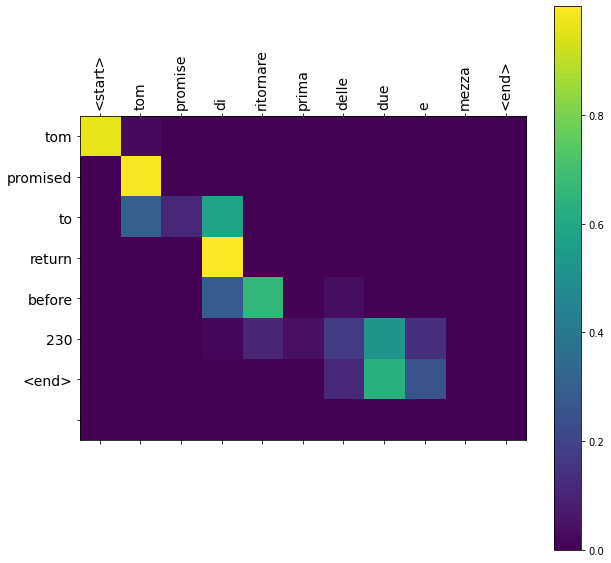

In [ ]:
translate('tom promise di ritornare prima delle due e mezza')

##For general model

In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  sentence = preprocess_ita(input_sentence).strip()
  inputs=tknizer_ita.texts_to_sequences(sentence)

  inputs = [tknizer_ita.word_index[i] for i in sentence.split(' ') if i in tknizer_ita.word_docs ]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                        maxlen=20,
                                                        padding='post')
  attention_plot = np.zeros((20, 20))
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  hidden = tf.zeros((1, 256))
  enc_out, enc_hidden,enc_cell_state = model_gen.layers[0](inputs, hidden)
  dec_hidden = [enc_hidden,enc_cell_state]
  dec_input = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)
  for t in range(20):
    predictions, dec_hidden, dec_cell_state,attention_weights,context_vector = model_gen.layers[1].onestepdecoder(dec_input,enc_out,dec_hidden[0],dec_hidden[1])
    dec_hidden=[dec_hidden, dec_cell_state]
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()

    result += tknizer_eng.index_word[predicted_id] + ' '

    if tknizer_eng.index_word[predicted_id] == '<end>':
      return result, '<start> '+sentence+' <end>',attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)





In [ ]:
def translate(sentence):
  result, sentence, attention_plot = predict(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> tom promise di ritornare prima delle due e mezza <end>
Predicted translation: tom promised to return before 230 <end> 


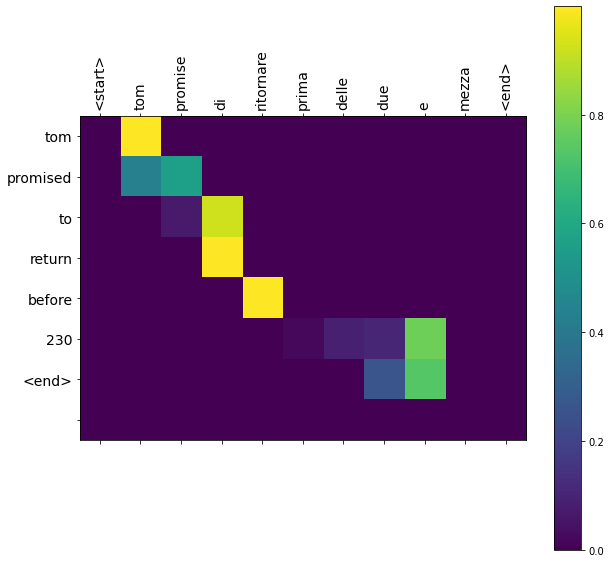

In [ ]:
translate('tom promise di ritornare prima delle due e mezza')

##For dot model

In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  sentence = preprocess_ita(input_sentence).strip()
  inputs=tknizer_ita.texts_to_sequences(sentence)

  inputs = [tknizer_ita.word_index[i] for i in sentence.split(' ') if i in tknizer_ita.word_docs ]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                        maxlen=20,
                                                        padding='post')
  attention_plot = np.zeros((20, 20))
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  hidden = tf.zeros((1, 256))
  enc_out, enc_hidden,enc_cell_state = model_dot.layers[0](inputs, hidden)
  dec_hidden = [enc_hidden,enc_cell_state]
  dec_input = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)
  for t in range(20):
    predictions, dec_hidden, dec_cell_state,attention_weights,context_vector = model_dot.layers[1].onestepdecoder(dec_input,enc_out,dec_hidden[0],dec_hidden[1])
    dec_hidden=[dec_hidden, dec_cell_state]
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()

    result += tknizer_eng.index_word[predicted_id] + ' '

    if tknizer_eng.index_word[predicted_id] == '<end>':
      return result, '<start> '+sentence+' <end>',attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)





In [ ]:
def translate(sentence):
  result, sentence, attention_plot = predict(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> tom promise di ritornare prima delle due e mezza <end>
Predicted translation: tom promised to return before 230 <end> 


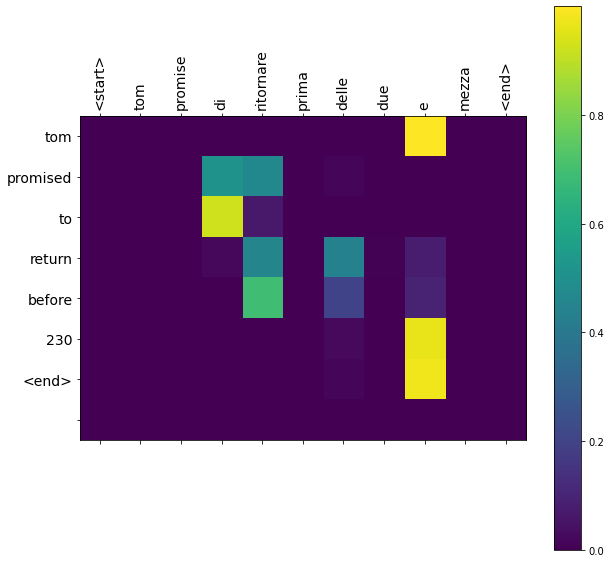

In [ ]:
translate('tom promise di ritornare prima delle due e mezza')

<font color='blue'>**Calculate BLEU score**</font>

##For concat

In [ ]:
def predict_bleu(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  sentence = preprocess_ita(input_sentence).strip()
  inputs=tknizer_ita.texts_to_sequences(sentence)

  inputs = [tknizer_ita.word_index[i] for i in sentence.split(' ') if i in tknizer_ita.word_docs ]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                        maxlen=20,
                                                        padding='post')
  attention_plot = np.zeros((20, 20))
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  hidden = tf.zeros((1, 256))
  enc_out, enc_hidden,enc_cell_state = model_con.layers[0](inputs, hidden)
  dec_hidden = [enc_hidden,enc_cell_state]
  dec_input = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)
  for t in range(20):
    predictions, dec_hidden, dec_cell_state,attention_weights,context_vector = model_con.layers[1].onestepdecoder(dec_input,enc_out,dec_hidden[0],dec_hidden[1])
    dec_hidden=[dec_hidden, dec_cell_state]
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()

    result += tknizer_eng.index_word[predicted_id] + ' '

    if tknizer_eng.index_word[predicted_id] == '<end>':
      return result

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)





In [ ]:
target=validation['italian'][1000:2000].apply(predict_bleu)

In [ ]:
import nltk.translate.bleu_score as bleu
reference = validation['english_out'][1000:2000] # the original
#translation = validation['italian'][10000:20000].apply(predict)[1]
#target=validation['italian'][10000:20000].apply(predict)[1] # trasilated using model
#print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))

In [ ]:
from tqdm import tqdm
score=0
for i,j in tqdm(zip(reference,target)):
  #print(i,j)
  score+=bleu.sentence_bleu([i.split()], j.split())

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
1000it [00:00, 9829.13it/s]


In [ ]:
print('BLEU score: {}'.format(score/1000))


BLEU score: 0.8167548702668879


##For general

In [ ]:
def predict_bleu(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  sentence = preprocess_ita(input_sentence).strip()
  inputs=tknizer_ita.texts_to_sequences(sentence)

  inputs = [tknizer_ita.word_index[i] for i in sentence.split(' ') if i in tknizer_ita.word_docs ]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                        maxlen=20,
                                                        padding='post')
  attention_plot = np.zeros((20, 20))
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  hidden = tf.zeros((1, 256))
  enc_out, enc_hidden,enc_cell_state = model_gen.layers[0](inputs, hidden)
  dec_hidden = [enc_hidden,enc_cell_state]
  dec_input = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)
  for t in range(20):
    predictions, dec_hidden, dec_cell_state,attention_weights,context_vector = model_gen.layers[1].onestepdecoder(dec_input,enc_out,dec_hidden[0],dec_hidden[1])
    dec_hidden=[dec_hidden, dec_cell_state]
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()

    result += tknizer_eng.index_word[predicted_id] + ' '

    if tknizer_eng.index_word[predicted_id] == '<end>':
      return result

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)





In [ ]:
target=validation['italian'][1000:2000].apply(predict_bleu)

In [ ]:
translation=[]
for j in target:
  translation.append(j)


In [ ]:
import nltk.translate.bleu_score as bleu
reference = validation['english_out'][1000:2000] # the original
#translation = validation['italian'][10000:20000].apply(predict)[1]
#target=validation['italian'][10000:20000].apply(predict)[1] # trasilated using model
#print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))

In [ ]:
from tqdm import tqdm
score=0
z=0
for i,j in tqdm(zip(reference,translation)):
  if type(j)==str:
  #print(i,j)
    score+=bleu.sentence_bleu([i.split()], j.split())
  else:
    z=z+1

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
1000it [00:00, 10088.72it/s]


In [ ]:
z

0

In [ ]:
print('BLEU score: {}'.format(score/1000))


BLEU score: 0.7962420761881754


##For dot model

In [ ]:
def predict_bleu(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  sentence = preprocess_ita(input_sentence).strip()
  inputs=tknizer_ita.texts_to_sequences(sentence)

  inputs = [tknizer_ita.word_index[i] for i in sentence.split(' ') if i in tknizer_ita.word_docs ]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                        maxlen=20,
                                                        padding='post')
  attention_plot = np.zeros((20, 20))
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  hidden = tf.zeros((1, 256))
  enc_out, enc_hidden,enc_cell_state = model_dot.layers[0](inputs, hidden)
  dec_hidden = [enc_hidden,enc_cell_state]
  dec_input = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)
  for t in range(20):
    predictions, dec_hidden, dec_cell_state,attention_weights,context_vector = model_dot.layers[1].onestepdecoder(dec_input,enc_out,dec_hidden[0],dec_hidden[1])
    dec_hidden=[dec_hidden, dec_cell_state]
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()

    result += tknizer_eng.index_word[predicted_id] + ' '

    if tknizer_eng.index_word[predicted_id] == '<end>':
      return result

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)





In [ ]:
target=validation['italian'][1000:2000].apply(predict_bleu)

In [ ]:
import nltk.translate.bleu_score as bleu
reference = validation['english_out'][1000:2000] # the original
#translation = validation['italian'][10000:20000].apply(predict)[1]
#target=validation['italian'][10000:20000].apply(predict)[1] # trasilated using model
#print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))

In [ ]:
from tqdm import tqdm
score=0
z=0
for i,j in tqdm(zip(reference,target)):
  if type(j)==str:
  #print(i,j)
    score+=bleu.sentence_bleu([i.split()], j.split())
  else:
    z=z+1

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
1000it [00:00, 9430.66it/s]


In [ ]:
z

0

In [ ]:
print('BLEU score: {}'.format(score/1000))


BLEU score: 0.799617013286298


## Observations

# 1.Here,we can see, by using concat attetion scoring function, the bleu score that we are getting is really good
# 2.The Bleu score for dot and general model is almost same.'
# 3. But here, we can see, attention models are performing really good as compare to vanilla encoder-decoder model.
# 4. Here, we can models are tends to overfit.So here, we need large amount of data to train